In [1]:
import os
import pickle
from natsort import natsorted
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import oapackage as oa
from natsort import natsorted
import Orange

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib
%matplotlib inline

# Model Selection
## integrate three selection strategies


In [2]:
# functions for DTO
def l2norm(matrix_1, matrix_2):
    """calculate Euclidean distance
    Args:
        matrix_1 (n*d np array): n is the number of instances, d is num of metric
        matrix_2 (n*d np array): same as matrix_1
    Returns:
        float: the row-wise Euclidean distance 
    """
    return np.power(np.sum(np.power(matrix_1-matrix_2, 2), axis=1), 0.5)
    

def DTO(performacne_metric):
    """calculate DTO for each condidate model
    Args:
        performacne_metric (array): 2D array, row: models, column: AUC of different subgroups
    """

    normalized_metric = np.zeros(performacne_metric.shape)
    utopias = []
    for i in range(performacne_metric.shape[1]):
        utopias.append(np.max(performacne_metric[:, i]))
        normalized_metric[:, i] = performacne_metric[:, i] / np.max(performacne_metric[:, i])
    
    # Calculate Euclidean distance
    distances = l2norm(normalized_metric, np.ones_like(normalized_metric))
    
    # return the index of model with the smallest distance
    return np.argmin(distances)

In [3]:
# Functions for Pareto

def find_mingroup(df):
    aucs = df[list(df.filter(regex=("auc-group")))]
    aucs = aucs.to_numpy()
    maxs = []
    for i in range(aucs.shape[1]):
        temp = aucs[:, i].tolist()
        maxs.append(max(temp))
    min_idx = np.argmin(maxs)
    return min_idx
    

def get_groups(df, metric = 'auc'):
    aucs = df[natsorted(list(df.filter(regex=(metric+'-group'))))].values.T
    groups = []
    for i in range((aucs.shape[0])):
        groups.append(aucs[i, :].astype('float'))
    return groups

def cal_pareto(groups, min_group_no):
    pareto=oa.ParetoDoubleLong()
    for i in range(groups[0].shape[0]):
        w= oa.doubleVector(tuple([group[i] for group in groups]))
        pareto.addvalue(w, i)
    datapoints = np.stack(groups)
    lst=pareto.allindices()
    optimal_datapoints=datapoints[:,lst]

    loc = np.argmax(optimal_datapoints.T[:, min_group_no])
    #loc = np.argmax(optimal_datapoints.T[:, 1])
    return lst[loc]


In [3]:
# config

exp_dict = {'HAM10000': [{'attribute': 'Sex', 'sens_num': 2}], 'HAM100004': [{'attribute': 'Age', 'sens_num': 4}], 
           'CXP': [{'attribute': 'Age', 'sens_num': 5}, {'attribute': 'Sex', 'sens_num': 2}, {'attribute': 'Race', 'sens_num': 2}],
           'MIMIC_CXR': [{'attribute': 'Age', 'sens_num': 5}, {'attribute': 'Sex', 'sens_num': 2}, {'attribute': 'Race', 'sens_num': 2}],
           'PAPILA': [{'attribute': 'Age', 'sens_num': 2}, {'attribute': 'Sex', 'sens_num': 2}],
           'ADNI': [{'attribute': 'Age', 'sens_num': 2}, {'attribute': 'Sex', 'sens_num': 2}],
           'OCT': [{'attribute': 'Age', 'sens_num': 2}],
           'COVID_CT_MD': [{'attribute': 'Age', 'sens_num': 2}, {'attribute': 'Sex', 'sens_num': 2}],
           'Fitz17k': [{'attribute': 'skin_type', 'sens_num': 6}],}

model_selections = ['overall_auc', 'pareto', 'DTO']
methods = ['baseline', 'resampling', 'DomainInd', 'LAFTR', 'CFair','LNL', 'EnD', 'ODR', 'GroupDRO', 'SWAD', 'SAM']
path = 'your_path/fariness_data/model_records/'

In [29]:
results = pd.DataFrame()

for model_selection in model_selections:
    for key, sens_exps in exp_dict.items():
        dataset = key
        for sens_exp in sens_exps:
            attribute = sens_exp['attribute']
            sens_num = sens_exp['sens_num']
            if dataset in ['OCT', 'ADNI', 'COVID_CT_MD']:
                backbone = 'cusResNet18_3d'
            elif dataset in ['RadFusion_EHR']:
                backbone = 'cusMLP'
            else:
                backbone = 'cusResNet18'
            
            means, stds, hashs = [], [], []
            #index = []
            mean_metrics = pd.DataFrame()
            std_metrics = pd.DataFrame()

            for method in methods:
                
                val_stats = natsorted(glob.glob(path + '/{datas}/{attr}/{bkb}/{meth}/*_val_pred_stat.csv'
                                                 .format(datas = dataset, attr = attribute, bkb = backbone, meth = method)))
                
                test_stats = natsorted(glob.glob(path + '/{datas}/{attr}/{bkb}/{meth}/*_test_pred_stat.csv'
                                                 .format(datas = dataset, attr = attribute, bkb = backbone, meth = method)))
                
                val_metrics = pd.DataFrame()
                
                for val_stat in val_stats:
                    hash_id = val_stat.split('/')[-1].split('_')[1]
                    val_stat_df = pd.read_csv(val_stat)
                    val_stat_df['hash'] = hash_id
                    val_metrics = pd.concat([val_metrics, pd.DataFrame(val_stat_df.iloc[0]).T], ignore_index=True)
                
                # decide min/max AUC group before selection
                if method == 'baseline':
                    min_group_no = find_mingroup(val_metrics)

                # model selection --> find hash id
                if model_selection == 'overall_auc':
                    hash_id = val_metrics.iloc[pd.to_numeric(val_metrics['Val Overall AUC']).idxmax()]['hash']
                elif model_selection == 'DTO':
                    aucs = val_metrics[list(val_metrics.filter(regex=("auc-group")))].values
                    model_idx = DTO(aucs)
                    hash_id = val_metrics.iloc[model_idx]['hash']
                elif model_selection == 'pareto':
                    groups = get_groups(val_metrics, 'auc')
                    lst_loc = cal_pareto(groups, min_group_no)
                    hash_id = val_metrics.iloc[lst_loc]['hash']
                else:
                    raise ValueError("selection strategy not supported")
                    
                hashs.append(hash_id)
                test_result = pd.read_csv(path + '/{datas}/{attr}/{bkb}/{meth}/{meth}_{hashid}_test_pred_stat.csv'
                                                 .format(datas = dataset, attr = attribute, bkb = backbone,meth = method, hashid = hash_id))
                
                mean_metrics = pd.concat([mean_metrics, pd.DataFrame(test_result.iloc[0]).T])
                std_metrics = pd.concat([std_metrics, pd.DataFrame(test_result.iloc[1]).T])
        
            try:
                mean_metrics = mean_metrics.drop(columns = ['Unnamed: 0'])
                std_metrics = std_metrics.drop(columns = ['Unnamed: 0'])
            except:
                pass

            mean_metrics = mean_metrics.astype('float').round(4)
            std_metrics = std_metrics.astype('float').round(3)
                
            out = pd.concat([mean_metrics.reset_index(drop=True).stack(), std_metrics.reset_index(drop=True).stack()], axis=1) \
                    .apply(lambda x: u"\u00B1".join(x.astype('str')), axis=1) \
                    .unstack()
            out['methods'] = methods

            out = out[ ['methods'] + [ col for col in out.columns if col != 'methods' ] ]
            out['hash'] = hashs

            out.to_csv('./results/selections/{}/{}-{}.csv'.format(model_selection, dataset, attribute), index = False)


/home/co-zong1/.conda/envs/torch11/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### Calculate Max/Min/Gap for Different selections


In [31]:
def get_max_min_gap(df_ori):
    df = df_ori.copy()
    mean_std = df.drop(columns=['hash']).to_numpy()

    rt = np.char.split(mean_std[:, 1:].astype('str'), u"\u00B1")
    means = np.zeros(rt.shape)
    
    for i in range(rt.shape[0]):
        for j in range(rt.shape[1]):
            means[i][j] = float(rt[i][j][0])
    means = pd.DataFrame(means, columns = df.columns[1:-1])

    aucs = means[list(means.filter(regex=("auc-group")))]
    aucs = aucs.to_numpy()
    max_auc, min_auc = [], []
    for i in range(aucs.shape[0]):
        temp = aucs[i].tolist()
        max_auc.append(max(temp))
        min_auc.append(min(temp))
    gap = np.asarray(max_auc)-np.asarray(min_auc)
    return np.asarray(max_auc), np.asarray(min_auc), gap


test_results_path = 'your_path/results/selections/'
selections = ['DTO', 'overall_auc', 'pareto']
for selection in selections:
    exp_paths = os.listdir(os.path.join(test_results_path, selection))
    for exp_path in exp_paths:
        
        result_path = os.path.join(test_results_path, selection, exp_path)
        results = pd.read_csv(result_path)
        # cal
        max_auc, min_auc, gap = get_max_min_gap(results)
        results['Max AUC'] = max_auc
        results['Min AUC'] = min_auc
        results['AUC Gap'] = gap
    
        results.to_csv(result_path, index = False)

### Calculate EqOdd for non-binary subgroups for completeness

## rank them

In [ ]:
methods = ['baseline', 'resampling', 'DomainInd', 'LAFTR', 'CFair', 'LNL', 'EnD', 'ODR', 'GroupDRO', 'SWAD', 'SAM']
for selection in selections:
    result_path = './results/selections/{}/'.format(selection)
    results = glob.glob(result_path + '*.csv')

    for result in results:
        names = result.split('/')[-1].split('.csv')[0].split('-')
        dataset, sensitive  = names[0], names[1]
        #if dataset != 'RadFusion_EHR':
        #    continue
        
        mean_std_df = pd.read_csv(result).drop(columns=['hash'])
        
        mean_std = mean_std_df.to_numpy()
        
        rt = np.char.split(mean_std[:, 1:].astype('str'), u"\u00B1")
        means = np.zeros(rt.shape)
        
        for i in range(rt.shape[0]):
            for j in range(rt.shape[1]):
                means[i][j] = float(rt[i][j][0])
        means = pd.DataFrame(means, columns = mean_std_df.columns[1:])
        # todo some ascending, some descending
        means = means.rank(ascending = False, numeric_only = True)
        try:
            means['methods'] = methods
        except:
            means['methods'] = mean_std_df['methods']
        means = means[ ['methods'] + [ col for col in means.columns if col != 'methods' ] ]
    
        means.to_csv('./results/selections/{}/{}-{}.csv'.format(selection+'_rank', dataset, sensitive), index = False)
means

## Statistic Test

In [4]:
import numpy as np
import pandas as pd
from scipy import stats
import scikit_posthocs as sp
import glob
import Orange
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
selections = ['overall_auc', 'pareto', 'DTO']
Metrics = ['Min AUC', 'AUC Gap', 'Test Overall AUC']
methods_toplot = ['ERM', 'Resampling', 'DomainInd', 'LAFTR', 'CFair', 'LNL', 'EnD', 'ODR', 'GroupDRO', 'SWAD', 'SAM']

for metric in Metrics:
    for selection in selections:
        result_path = './results/selections/{}/'.format(selection + '_rank')
        
        results = glob.glob(result_path + '*.csv')
    
        min_ranks, max_ranks, gap_ranks, overall_ranks = [], [], [], []
        ranks = []
        for result in results:
            names = result.split('/')[-1].split('.csv')[0].split('-')
            dataset, sensitive  = names[0], names[1]
            if dataset not in exp_dict.keys():
                continue
            
            mean_std_df = pd.read_csv(result)
            
            values = mean_std_df[metric].values
            if metric == 'AUC Gap':
                values = 12 - values
            ranks.append(values)
    
            avgrank = np.nanmean(ranks, 0)
            
        cd = Orange.evaluation.compute_CD(avgrank, len(ranks), alpha='0.05', test='nemenyi') 
        print('cd=', cd)
        Orange.evaluation.graph_ranks(avgrank, methods_toplot, cd=cd, width=5, textspace=1.5,
                                filename = 'results/selections/cd_diagrams/{}_{}_in_distribution.pdf'.format(selection, metric))

    

### Results of Baseline under different model selections

### rank across datasets

In [ ]:
selections = ['overall_auc', 'DTO', 'pareto']
#Metrics = ['Max AUC', 'Min AUC', 'AUC Gap', 'Test Overall AUC']
Metrics = ['Test Overall AUC']

methods_toplot = ['ERM']
total_df = pd.DataFrame()

for selection in selections:
    
    value_path = './results/selections/{}/'.format(selection)
    value_results = natsorted(glob.glob(value_path + '*.csv'))

    mean_values = []
    column_names = []
    for value_result in value_results:
        dataset, sensitive = value_result.split('/')[-1].split('.csv')[0].split('-')
        column_names.append(dataset  + '-' + sensitive)

        # process values
        value_df = pd.read_csv(value_result).drop(columns=['hash'])
        mean_std = value_df.to_numpy()
        
        rt = np.char.split(mean_std[:, 1:].astype('str'), u"\u00B1")
        means = np.zeros(rt.shape)
        
        for i in range(rt.shape[0]):
            for j in range(rt.shape[1]):
                means[i][j] = float(rt[i][j][0])
        means = pd.DataFrame(means, columns = value_df.columns[1:])

        values = means[Metrics].iloc[0]
        mean_values.append(values)

    mean_values = np.stack(mean_values).squeeze()
        
    total_df = pd.concat([total_df, pd.DataFrame([mean_values], columns=column_names)])

total_df['Selection Strategy'] = ['Overall Performance', 'DTO', 'Pareto Optimal']
total_df = total_df[ ['Selection Strategy'] + [ col for col in total_df.columns if col != 'Selection Strategy' ] ]
total_df

total_rank_df = total_df.rank(ascending = False, numeric_only = True)
rank_values = total_rank_df.to_numpy()
avgrank = np.mean(rank_values, axis=1)

cd = Orange.evaluation.compute_CD(avgrank, 16, alpha='0.05', test='nemenyi') #tested on 13 datasets 
print('cd=', cd)
Orange.evaluation.graph_ranks(avgrank, total_df['Selection Strategy'].values, cd=cd, width=5, textspace=1.5,
                        filename = 'results/selections/cd_diagrams/{}_{}_in_distribution.pdf'.format(selection, metric))
           

## Plot for ”Bias widely exists“

In [3]:
selections = ['overall_auc']
#Metrics = ['Max AUC', 'Min AUC', 'AUC Gap', 'Test Overall AUC']
Metrics = ['AUC Gap']

def get_aucs(dataset, sensitive, mode = 'id'):
    
    filename = dataset + '-' + sensitive + '.csv'
    result_path = './results/selections/overall_auc/'
    mean_std_df = pd.read_csv(result_path + filename).drop(columns=['hash'])
    
    mean_std = mean_std_df.to_numpy()

    rt = np.char.split(mean_std[:, 1:].astype('str'), u"\u00B1")
    means = np.zeros(rt.shape)
    
    for i in range(rt.shape[0]):
        for j in range(rt.shape[1]):
            means[i][j] = float(rt[i][j][0])
            #stds[i][j] = float(rt[i][j][1])
    means = pd.DataFrame(means, columns = mean_std_df.columns[1:])

    aucs = means[list(means.filter(regex=("auc-group")))].iloc[0].values.tolist()
    max_auc, min_auc = np.max(aucs), np.min(aucs)

    if dataset in ['MIMIC_CXR', 'CXP']:
        fprs = means[list(means.filter(regex=("FPR-group")))].iloc[0].values.tolist()
        max_under, min_under = np.max(fprs), np.min(fprs)
    else:
        fnrs = means[list(means.filter(regex=("FNR-group")))].iloc[0].values.tolist()
        max_under, min_under = np.max(fnrs), np.min(fnrs)


    return max_auc, min_auc, max_under, min_under #np.asarray(max_auc), , harmonic_mean


total_df = pd.DataFrame()
for selection in selections:
    
    value_path = './results/selections/{}/'.format(selection)
    value_results = natsorted(glob.glob(value_path + '*.csv'))

    maxs, mins, max_unders, min_unders, names = [], [], [], [], []
    for value_result in value_results:
        dataset, sensitive = value_result.split('/')[-1].split('.csv')[0].split('-')
        
        max_auc, min_auc, max_under, min_under = get_aucs(dataset, sensitive)
        
        maxs.append(max_auc)
        mins.append(min_auc)
        max_unders.append(max_under)
        min_unders.append(min_under)
        names.append(dataset+'-'+sensitive)


In [6]:
names = ['ADNI-Age', 'ADNI-Sex', 'COVID_CT_MD-Age', 'COVID_CT_MD-Sex', 'CheXpert-Age', 'CheXpert-Sex', 'CheXpert-Race', 
'Fitzpatrick17k-skin_type', 'HAM10000-Sex', 'HAM10000-Age', 'MIMIC_CXR-Age', 'MIMIC_CXR-Race', 
'MIMIC_CXR-Sex', 'OCT-Age', 'PAPILA-Age', 'PAPILA-Sex']

In [7]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

<AxesSubplot:xlabel='Min Underdiagnosis Rate', ylabel='Max Underdiagnosis Rate'>

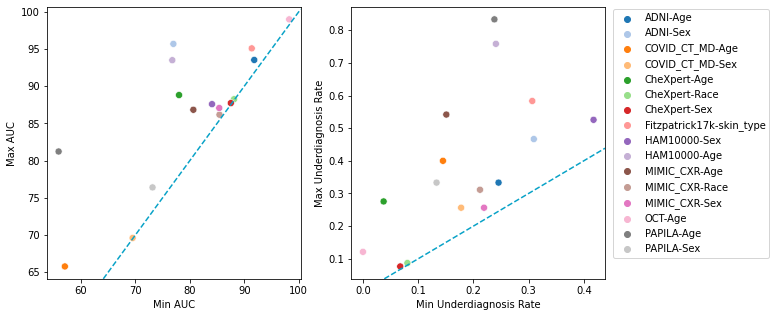

In [16]:
df = pd.DataFrame([names, maxs, mins], index = ['Datasets', 'Max AUC', 'Min AUC']).T
df2 = pd.DataFrame([names, max_unders, min_unders], index = ['Datasets', 'Max Underdiagnosis Rate', 'Min Underdiagnosis Rate']).T
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
sns.scatterplot(data = df, x = 'Min AUC', y = 'Max AUC', hue = 'Datasets', s = 50, palette = 'tab20', ax = ax)
#ax.legend(bbox_to_anchor=(1.01, 1.05))
ax.get_legend().remove()
add_identity(ax, color="#08a2c7", ls='--')

ax2 = fig.add_subplot(122)
sns.scatterplot(data = df2, x = 'Min Underdiagnosis Rate', y = 'Max Underdiagnosis Rate', hue = 'Datasets', s = 50, palette = 'tab20', ax = ax2)
ax2.legend(bbox_to_anchor=(1.01, 1.01))
add_identity(ax2, color="#08a2c7", ls='--')
plt.savefig('./results/plots/bias_exists.png', dpi = 400, bbox_inches = 'tight')